In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
rcParams['figure.figsize'] = 15, 6
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'k'

In [2]:
data = pd.read_csv('tatavg.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)
print (data.size)

          Date  Average Price
0  01-Jan-2018         430.49
1  02-Jan-2018         433.41
2  03-Jan-2018         435.06
3  04-Jan-2018         429.56
4  05-Jan-2018         432.92

 Data Types:
Date              object
Average Price    float64
dtype: object
494


In [3]:
data.head(10)

,Date,Average Price
0,01-Jan-2018,430.49
1,02-Jan-2018,433.41
2,03-Jan-2018,435.06
3,04-Jan-2018,429.56
4,05-Jan-2018,432.92
5,08-Jan-2018,433.92
6,09-Jan-2018,438.96
7,10-Jan-2018,434.76
8,11-Jan-2018,435.64
9,12-Jan-2018,437.06


In [4]:
data = pd.read_csv('tatavg.csv', parse_dates=['Date'], index_col='Date')
print (data.head())

            Average Price
Date                     
2018-01-01         430.49
2018-01-02         433.41
2018-01-03         435.06
2018-01-04         429.56
2018-01-05         432.92


In [5]:
data.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-31', '2019-01-01'],
              dtype='datetime64[ns]', name='Date', length=247, freq=None)

In [6]:
#Converting to time series
ts = data['Average Price']
print(ts.head())

Date
2018-01-01    430.49
2018-01-02    433.41
2018-01-03    435.06
2018-01-04    429.56
2018-01-05    432.92
Name: Average Price, dtype: float64


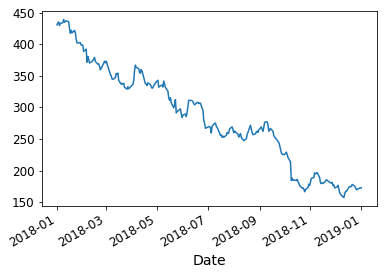

In [28]:
ts.plot()

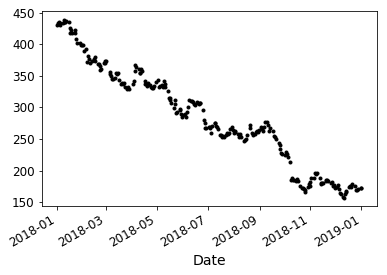

In [8]:
#Visualizing our time series data
ts.plot(style='k.')
plt.show()

In [9]:
#Checking the stationarity of the time series data, techniques are - 
#1) Rolling statistics 
#2) Dickey-Fuller Test
#Clearly there is an increasing trend: taking the Rolling Statistics technique
from statsmodels.tsa.stattools import adfuller

#Creating a function for stationarity check

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    #print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in dftest[4].items():
     #   dfoutput['Critical Value (%s)'%key] = value
    #print (dfoutput)
    
#The function ends here

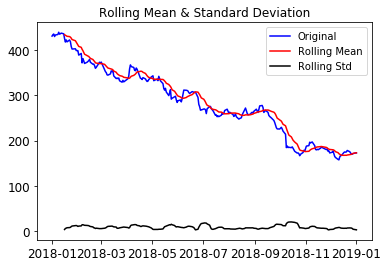

In [10]:
#Calling the function for checking stationarity
test_stationarity(ts)

Date
2018-01-01        NaN
2018-01-02        NaN
2018-01-03        NaN
2018-01-04        NaN
2018-01-05        NaN
2018-01-08        NaN
2018-01-09        NaN
2018-01-10        NaN
2018-01-11        NaN
2018-01-12        NaN
2018-01-15        NaN
2018-01-16   -0.01988
Name: Average Price, dtype: float64

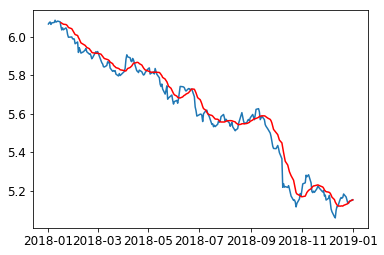

In [11]:
#Making the time series stationary by removing:
#1. Trend and 2. Stationarity
#1. Removing trend : Taking log transform and applying smoothing-moving average
ts_log = np.log(ts)
#Plot after log transform
#plt.plot(ts_log)    
#plotting log transform and moving average together
moving_avg = ts_log.rolling(window=12, center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
#Taking difference from the original series
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

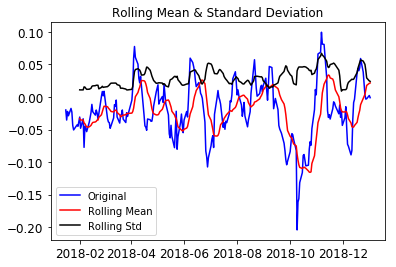

In [12]:
#Dropping the NaN values
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

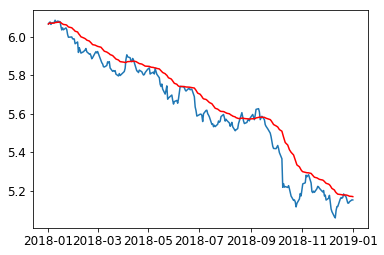

In [13]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
#expwighted_avg = ts_log.ewma(ups, span=RSI_N)[-1]
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

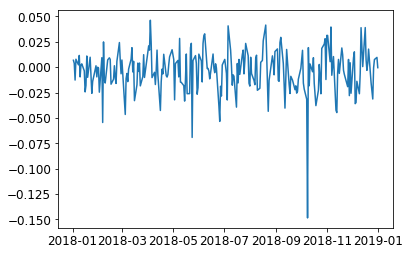

In [14]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

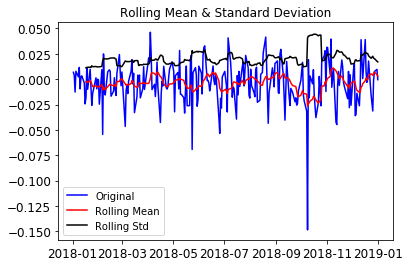

In [15]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

C:\Users\komv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\komv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.1079')

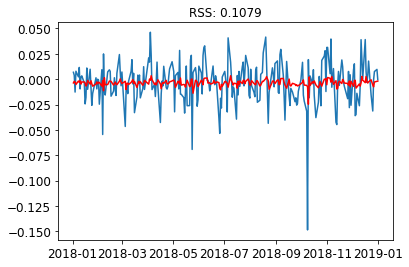

In [16]:
#AR MODEL
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\Users\komv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\komv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.1079')

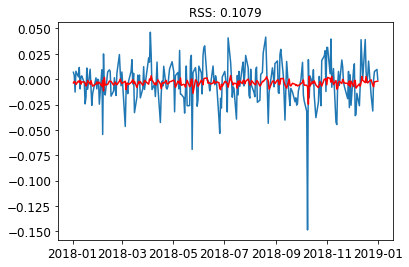

In [17]:
#MA MODEL
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

C:\Users\komv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\komv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.1076')

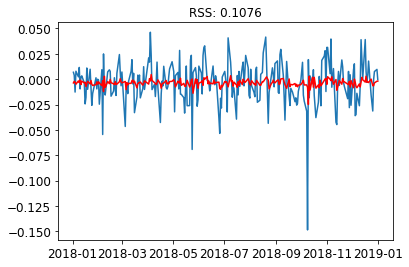

In [18]:
#ARIMA MODEL
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [19]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2018-01-02   -0.003705
2018-01-03   -0.002178
2018-01-04   -0.002807
2018-01-05   -0.004944
2018-01-08   -0.001740
dtype: float64


In [20]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2018-01-02   -0.003705
2018-01-03   -0.005884
2018-01-04   -0.008691
2018-01-05   -0.013635
2018-01-08   -0.015375
dtype: float64


In [21]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\komv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2018-01-01    6.064924
2018-01-02    6.061219
2018-01-03    6.059041
2018-01-04    6.056233
2018-01-05    6.051289
dtype: float64

Text(0.5,1,'RMSE: 15.1693')

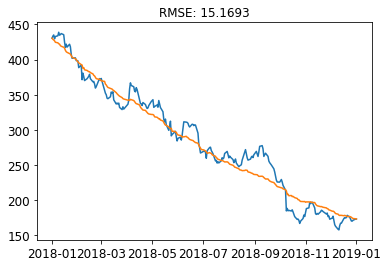

In [22]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [29]:
predictions_ARIMA.head(10)

Date
2018-01-01    430.490000
2018-01-02    428.897794
2018-01-03    427.964631
2018-01-04    426.764876
2018-01-05    424.660247
2018-01-08    423.921791
2018-01-09    422.486749
2018-01-10    422.084049
2018-01-11    419.849361
2018-01-12    419.049347
dtype: float64

Date
2018-01-02   -0.003706
2018-01-03   -0.002181
2018-01-04   -0.002773
2018-01-05   -0.005171
2018-01-08   -0.001847
dtype: float64
Date
2018-01-02   -0.003706
2018-01-03   -0.005887
2018-01-04   -0.008659
2018-01-05   -0.013830
2018-01-08   -0.015678
dtype: float64


C:\Users\komv\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,'RMSE: 15.3445')

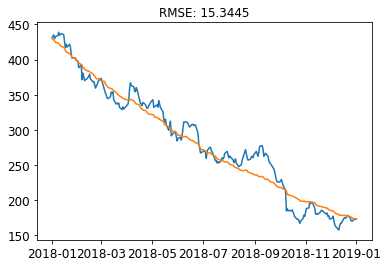

In [23]:
#AR model
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print (predictions_AR_diff.head())
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print (predictions_AR_diff_cumsum.head())
predictions_AR_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()
predictions_AR = np.exp(predictions_AR_log)
plt.plot(ts)
plt.plot(predictions_AR)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_AR-ts)**2)/len(ts)))

In [30]:
predictions_AR.head(10)

Date
2018-01-01    430.490000
2018-01-02    428.897581
2018-01-03    427.963281
2018-01-04    426.778298
2018-01-05    424.577110
2018-01-08    423.793538
2018-01-09    422.519146
2018-01-10    421.865617
2018-01-11    419.827441
2018-01-12    418.672124
dtype: float64

Date
2018-01-02   -0.003706
2018-01-03   -0.002184
2018-01-04   -0.002808
2018-01-05   -0.005173
2018-01-08   -0.001791
dtype: float64
Date
2018-01-02   -0.003706
2018-01-03   -0.005890
2018-01-04   -0.008698
2018-01-05   -0.013871
2018-01-08   -0.015661
dtype: float64


C:\Users\komv\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,'RMSE: 15.3632')

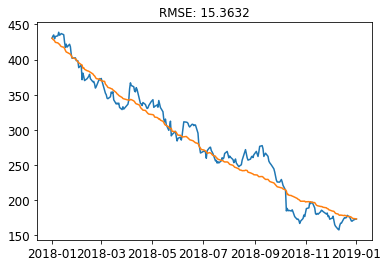

In [25]:
#MA model
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print (predictions_MA_diff.head())
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
print (predictions_MA_diff_cumsum.head())
predictions_MA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()
predictions_MA = np.exp(predictions_MA_log)
plt.plot(ts)
plt.plot(predictions_MA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))